Week 2: looked at how reviews change over time for top businesses, consider using different metrics for average stars, things like rolling average or the average for the last n period of time. 

In [ ]:
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime

In [ ]:
business_review_dict = pickle.load(open("business_reviews.pickle", "rb"))

In [ ]:
datetime.datetime(2016, 12, 1)

In [ ]:
relevant = {}
business_info = {}
with open("yelp_academic_dataset_business.json") as f:
    for line in f:
        json_line = json.loads(line)

        city = json_line["city"]
        business = json_line["business_id"]
        reviews = business_review_dict[business]
        num_reviews = len(reviews)
        avg_star = sum(reviews)/float(num_reviews)
        
        if city == "Phoenix":
            if num_reviews > 1500 and "Restaurants" in json_line["categories"]:
                print(json_line["name"])
                relevant[business] = []
                business_info[business] = json_line

In [ ]:
with open("yelp_academic_dataset_review.json") as f:
    for line in f:
        json_line = json.loads(line)
        if json_line["business_id"] in relevant:
            relevant[json_line["business_id"]].append(json_line)

In [ ]:
for b_id, reviews in relevant.items():
    counter = 0
    business = business_info[b_id]
    name = business["name"]
    sorted_reviews = sorted(reviews, key=lambda x: datetime.datetime.strptime(x['date'], '%Y-%m-%d'))
    seen_stars = []
    
    x = []
    avg = []
    
    x_interval = []
    avg_interval = []
    interval = 50
    
    date_to_count = {}
    date_to_reviews = {}
    for rev in sorted_reviews:
        date = datetime.datetime.strptime(rev['date'], '%Y-%m-%d')
        month = int(date.strftime('%m'))
        year = int(date.strftime('%Y'))
        if (year, month) in date_to_count:
            date_to_count[(year, month)] += 1
            date_to_reviews[(year, month)].append(rev["stars"])
        else:
            date_to_count[(year, month)] = 1
            date_to_reviews[(year, month)] = [rev["stars"]]
        
        counter += 1
        stars = rev["stars"]
        seen_stars.append(stars)
        x.append(len(seen_stars))
        avg.append(np.average(np.array(seen_stars)))
        
        if counter % interval == 0:
            x_interval.append(int(counter/interval))
            avg_int = np.average(np.array(seen_stars[-interval::]))
            avg_interval.append(avg_int)
    
    dates = []
    counts = []
    y = []
    for date, count in sorted(date_to_count.items(), key=lambda x:x[0]):
        formatted_date = datetime.datetime(date[0], date[1], 1)
        y.append(np.average(np.array(date_to_reviews[date])))
        dates.append(formatted_date)
        counts.append(count)
    sc = plt.scatter(dates, counts, c=y)
    plt.gray()
    plt.colorbar(sc)
    plt.title(name + " reviews per month")
    plt.xlabel("Date")
    plt.ylabel("Number of Reviews")
    plt.show()
            
    plt.plot(x, avg)
    plt.title(name)
    plt.xlabel("Reviews Over Time")
    plt.ylabel("Average Stars")
    plt.show()
    
    plt.scatter(x_interval, avg_interval)
    plt.plot(np.unique(x_interval), np.poly1d(np.polyfit(x_interval, avg_interval, 1))(np.unique(x_interval)))
    plt.title(name + " with review interval " + str(interval))
    plt.xlabel("Review Interval")
    plt.ylabel("Average Stars Over Interval")
    plt.show()

Week 3: Tried to create a new price metric from the $-$$$$ scales and words mentioned in the text. 

In [ ]:
import json
import pickle
import numpy as np
from nltk.corpus import wordnet as wn
import re

In [ ]:
counter = 0
total = 0
with open("yelp_academic_dataset_business.json") as f:
    for line in f:
        total += 1
        json_line = json.loads(line)
        if json_line["attributes"]:
            for att in json_line["attributes"]:
                m = re.match(r"RestaurantsPriceRange2:\s(\d)", att)
                if m:
                    counter += 1
print(counter, total)

In [ ]:
business_review_dict = pickle.load(open("business_reviews.pickle", "rb"))

In [ ]:
businesses = {}
size = 10000
count = 0
with open("yelp_academic_dataset_business.json") as f:
    if count < size:
        count += 1
        for line in f:
            json_line = json.loads(line)
            cats = json_line["categories"]
            if cats and "Restaurants" in json_line["categories"]:
                bus = json_line["business_id"]
                businesses[bus] = [json_line, []]

In [ ]:
with open("yelp_academic_dataset_review.json") as f:
    for line in f:
        json_line = json.loads(line)
        bus = json_line["business_id"]
        if bus in businesses:
            businesses[bus][1].append(json_line)

In [ ]:
cheap_words = {"cheap", "inexpensive"}
exp_words = {"expensive", "pricy", "pricey", "costly"}

cheap_adj = {"low", "good", "fair"}
exp_adj = {"bad", "high", "poor"}


# for s in wn.synsets("costly", pos=wn.ADJ):
#     print (s, s.lemma_names())
    
sent_list = []    

for bus, (b_info, reviews) in businesses.items():
    total = len(reviews)
    cheap_count = 0
    exp_count = 0
    for review in reviews:
        text = review["text"].split()
        for ind, word in enumerate(text):
            if word == "price" and ind > 0:
                if text[ind - 1] in cheap_adj:
                    cheap_count += 1
                elif text[ind - 1] in exp_adj:
                    exp_count += 1
            elif word in cheap_words:
                if ind > 0 and text[ind - 1] == "not":
                    exp_count += 1
                else:
                    cheap_count += 1
            elif word in exp_words:
                if ind > 0 and text[ind - 1] == "not":
                    cheap_count += 1
                else:
                    exp_count += 1
    sent_list.append((b_info, total, cheap_count, exp_count))    

In [ ]:
dollar_dict = {1: 8.0, 2: 20.0, 3: 45.0, 4: 70.0}
range_dict = {1: 5.0, 2: 19.0, 3: 29.0, 4: 50.0}
for (b_info, total, cheap_count, exp_count) in sent_list[100:200]:
    if b_info["attributes"]:
        price = None
        for att in b_info["attributes"]:
            m = re.match(r"RestaurantsPriceRange2:\s(\d)", att)
            if m:
                price = int(m.group(1))
        if price:
            adjusted = dollar_dict[price] - range_dict[price]*float(cheap_count)/total + range_dict[price]*float(exp_count)/total
            print(price, adjusted, total, cheap_count, exp_count)

Week 4: look at votes over time and work on the ML implementation

other features: num fans, num friends, yelping since

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import datetime as datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [2]:
with open("yelp_academic_dataset_user.json") as f:
    for l in f:
        line = json.loads(l)
        print(line.keys())
        break

[u'yelping_since', u'useful', u'compliment_photos', u'compliment_list', u'compliment_funny', u'funny', u'review_count', u'friends', u'fans', u'type', u'compliment_note', u'compliment_plain', u'compliment_writer', u'compliment_cute', u'average_stars', u'user_id', u'compliment_more', u'elite', u'compliment_hot', u'cool', u'name', u'compliment_profile', u'compliment_cool']


In [2]:
years_to_count = {}
with open("yelp_academic_dataset_user.json") as f:
    for line in f:
        json_line = json.loads(line)
        elites = json_line["elite"]
        if "None" not in elites:
            for yr in elites:
                yr_int = int(yr)
                if yr_int in years_to_count:
                    years_to_count[yr_int] += 1
                else:
                    years_to_count[yr_int] = 1

[2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005]


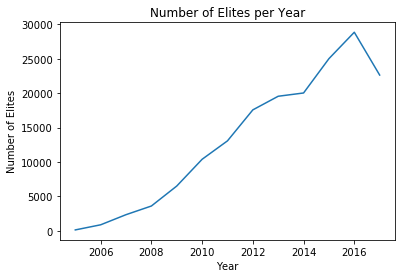

In [3]:
items = years_to_count.items()
sorted_items = sorted(items, key=lambda x:x[0], reverse=True)
years = [year for (year, count) in sorted_items]
counts = [count for (year, count) in sorted_items]
print years
plt.plot(years, counts)
plt.title("Number of Elites per Year")
plt.xlabel("Year")
plt.ylabel("Number of Elites")
plt.show()

In [5]:
def generate_features(feature_order):
    features = []
    labels = []
    with open("yelp_academic_dataset_user.json") as f:
        for l in f:
            line = json.loads(l)
            elites = line["elite"]
            feature = [line[feat] for feat in feature_order]
            features.append(feature)
            if "None" in elites:
                labels.append(0)
            else:
                labels.append(1)
    return features, labels

def run_random_forests(features, labels):
    seventy_mark = seventy_percent(features)
    clf = RandomForestClassifier()
    clf.fit(features[:seventy_mark], labels[:seventy_mark])

    preds = clf.predict(features[seventy_mark:])
    return preds, labels[seventy_mark:], clf.feature_importances_

def run_logistic_regression(features, labels):
    seventy_mark = seventy_percent(features)
    clf = LogisticRegression()
    clf.fit(features[:seventy_mark], labels[:seventy_mark])

    preds = clf.predict(features[seventy_mark:])
    return preds, labels[seventy_mark:], clf.coef_
    
def accuracy(actual, preds):
    correct = 0.0
    for ind, pred in enumerate(preds):
        if pred == actual[ind]:
            correct += 1
    return correct/len(actual)

def precision(actual, preds, val):
    num = 0.0
    den = 0.0
    for ind, pred in enumerate(preds):
        if pred == val:
            den += 1
            if actual[ind] == val:
                num += 1
    return num/den

def recall(actual, preds, val):
    num = 0.0
    den = 0.0
    for ind, act in enumerate(actual):
        if act == val:
            den += 1
            if preds[ind] == val:
                num += 1
    return num/den

def f1(p, r):
    return 2*p*r/(p+r)

def print_scores(actual, preds):
    print("Accuracy = " + str(accuracy(actual, preds)))
    p = precision(actual, preds, 1)
    r = recall(actual, preds, 1)
    f = f1(p, r)
    print("Elite: Precision = " + str(p) + ", Recall = " + str(r) +", F-1 score = " + str(f))
    
    p = precision(actual, preds, 0)
    r = recall(actual, preds, 0)
    f = f1(p, r)
    print("Non-Elite: Precision = " + str(p) + ", Recall = " + str(r) +", F-1 score = " + str(f) + "\n")

def seventy_percent(features):
    return int(0.7*len(features))

In [ ]:
which_features = ["useful", "compliment_photos", "compliment_list", "compliment_funny",
                  "funny", "compliment_note", "compliment_plain", "compliment_writer",
                  "compliment_cute", "compliment_more", "compliment_hot", "cool", 
                  "compliment_profile", "compliment_cool"]

features, labels = generate_features(which_features)
preds, actual, importances = run_random_forests(features, labels)
print("accuracy", accuracy(actual, preds))

for ind, importance in sorted(enumerate(importances), key=lambda x:x[1], reverse=True):
    print(which_features[ind], importance)

In [ ]:
which_features = ["useful", "compliment_photos", "compliment_list", "compliment_funny",
                  "funny", "compliment_note", "compliment_plain", "compliment_writer",
                  "compliment_cute", "compliment_more", "compliment_hot", "cool", 
                  "compliment_profile", "compliment_cool", "review_count"]

features, labels = generate_features(which_features)
preds, actual, importances = run_random_forests(features, labels)
print("accuracy", accuracy(actual, preds))
print("precision of elite", precision(actual, preds, 1))
print("recall of elite", recall(actual, preds, 1))
print("precision of non-elite", precision(actual, preds, 0))
print("recall of non-elite", recall(actual, preds, 0))

for ind, importance in sorted(enumerate(importances), key=lambda x:x[1], reverse=True):
    print(which_features[ind], importance)

Created the ML functionality for predicting if a user has been elite at any point or not in their entire yelping career. In the end, we get around 98-99% accuracy on if a user has ever been elite.

In [6]:
with open("yelp_academic_dataset_review.json") as f:
    for l in f:
        line = json.loads(l)
        print(line.keys())
        break

[u'funny', u'user_id', u'review_id', u'text', u'business_id', u'stars', u'date', u'useful', u'type', u'cool']


In [7]:
user_to_reviews = {}
with open("yelp_academic_dataset_review.json") as f:
    for l in f:
        line = json.loads(l)
        user = line["user_id"]
        if user in user_to_reviews:
            user_to_reviews[user].append(line)
        else:
            user_to_reviews[user] = [line]

In [8]:
user_to_years = {}
with open("yelp_academic_dataset_user.json") as f:
    for l in f:
        line = json.loads(l)
        elites = line["elite"]
        if "None" not in elites:
            years = {int(yr) for yr in elites}
            user_to_years[line["user_id"]] = years

In [9]:
elite_years = set(years_to_count.keys())
features = []
labels = []

elite_avg_stars = []
elite_avg_cool = []
elite_avg_useful = []
elite_avg_funny = []
elite_avg_reviews = []

non_avg_stars = []
non_avg_cool = []
non_avg_useful = []
non_avg_funny = []
non_avg_reviews = []

for user, reviews in user_to_reviews.items():
    year_to_reviews = {}
    for line in reviews:
        date = datetime.datetime.strptime(line['date'], '%Y-%m-%d')
        year = int(date.strftime('%Y'))
        if year in elite_years:
            if year in year_to_reviews:
                year_to_reviews[year].append(line)
            else:
                year_to_reviews[year] = [line]
    
    elite_before = 0
    for year, reviews in sorted(year_to_reviews.items(), key=lambda x:x[0]):
        feat = []
        
        n_funny = 0.0
        n_cool = 0.0
        n_useful = 0.0
        n_stars = 0.0
        n_reviews = len(reviews)
        for review in reviews:
            n_funny += review["funny"]
            n_cool += review["cool"]
            n_useful += review["useful"]
            n_stars += review["stars"]
        feat.extend([year, elite_before, n_reviews, n_funny, n_cool, n_useful, n_stars/n_reviews])
        features.append(feat)
        
        if user in user_to_years and year in user_to_years[user]:
            labels.append(1)
            elite_before = 1
            elite_avg_stars.append(n_stars/n_reviews)
            elite_avg_cool.append(n_cool)
            elite_avg_useful.append(n_useful)
            elite_avg_funny.append(n_funny)
            elite_avg_reviews.append(n_reviews)
        else:
            labels.append(0)
            non_avg_stars.append(n_stars/n_reviews)
            non_avg_cool.append(n_cool)
            non_avg_useful.append(n_useful)
            non_avg_funny.append(n_funny)
            non_avg_reviews.append(n_reviews)

In [10]:
which_features = ["year", "elite_before", "n_reviews", "n_funny", "n_cool", "n_useful", "avg_star"]

years = [x[0] for x in features]
indices = np.argsort(years)
s_features = [features[i] for i in indices]
s_labels = [labels[i] for i in indices]
preds, actual, importances = run_random_forests(s_features, s_labels)

print("Random Forests")
print_scores(actual, preds)
for ind, importance in sorted(enumerate(importances), key=lambda x:x[1], reverse=True):
    print(which_features[ind], importance)

Random Forests
Accuracy = 0.973626451509
Elite: Precision = 0.753349573691, Recall = 0.488326189939, F-1 score = 0.592554574694
Non-Elite: Precision = 0.979380435845, Recall = 0.99346444404, F-1 score = 0.986372167544

('elite_before', 0.34324957250486632)
('n_useful', 0.14884308185120462)
('n_cool', 0.1359397050289502)
('avg_star', 0.12214524815403049)
('n_funny', 0.10290060142675798)
('n_reviews', 0.080651559724834995)
('year', 0.066270231309355429)


In [11]:
which_features = ["year", "elite_before", "n_reviews", "n_funny", "n_cool", "n_useful", "avg_star"]

preds, actual, importances = run_logistic_regression(s_features, s_labels)

print("Logistic Regression")
print_scores(actual, preds)
for ind, importance in sorted(enumerate(importances[0]), key=lambda x:x[1], reverse=True):
    print(which_features[ind], importance)

Logistic Regression
Accuracy = 0.977889894643
Elite: Precision = 0.817608000656, Recall = 0.562485901196, F-1 score = 0.666466205606
Non-Elite: Precision = 0.982340649285, Recall = 0.994870683594, F-1 score = 0.988565963612

('elite_before', 4.5419293252492059)
('avg_star', 0.086312649312602685)
('n_reviews', 0.046685777825964253)
('n_cool', 0.03521930347804874)
('n_useful', 0.012337948384416677)
('year', -0.0019780395225400082)
('n_funny', -0.014789482718830091)


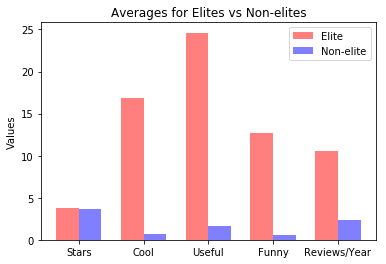

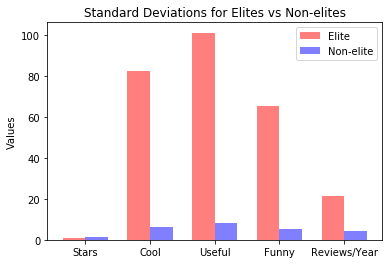

In [12]:
elite_avgs = (np.average(elite_avg_stars), np.average(elite_avg_cool), np.average(elite_avg_useful),
              np.average(elite_avg_funny), np.average(elite_avg_reviews))
non_avgs = (np.average(non_avg_stars), np.average(non_avg_cool), np.average(non_avg_useful),
              np.average(non_avg_funny), np.average(non_avg_reviews))

elite_stds = (np.std(elite_avg_stars), np.std(elite_avg_cool), np.std(elite_avg_useful),
              np.std(elite_avg_funny), np.std(elite_avg_reviews))
non_stds = (np.std(non_avg_stars), np.std(non_avg_cool), np.std(non_avg_useful),
              np.std(non_avg_funny), np.std(non_avg_reviews))

n_groups = 5

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.5
error_config = {'ecolor': '0.3'}

elite = plt.bar(index, elite_avgs, bar_width, alpha=opacity, color='r', label='Elite')
non = plt.bar(index + bar_width, non_avgs, bar_width, alpha=opacity, color='b', label='Non-elite')

# elite = plt.bar(index, elite_avgs, bar_width, alpha=opacity, color='r', 
#                 yerr=elite_stds, error_kw=error_config, label='Elite')
# non = plt.bar(index + bar_width, non_avgs, bar_width, alpha=opacity, color='b', 
#               yerr=non_stds, error_kw=error_config, label='Non-elite')

plt.ylabel('Values')
plt.title('Averages for Elites vs Non-elites')
plt.xticks(index + bar_width / 2, ('Stars', 'Cool', 'Useful', 'Funny', 'Reviews/Year'))
plt.legend()
plt.show()

fig, ax = plt.subplots()
error_config = {'ecolor': '0.3'}

elite = plt.bar(index, elite_stds, bar_width, alpha=opacity, color='r',
                 error_kw=error_config, label='Elite')
non = plt.bar(index + bar_width, non_stds, bar_width, alpha=opacity, color='b',
                 error_kw=error_config, label='Non-elite')

plt.ylabel('Values')
plt.title('Standard Deviations for Elites vs Non-elites')
plt.xticks(index + bar_width / 2, ('Stars', 'Cool', 'Useful', 'Funny', 'Reviews/Year'))
plt.legend()
plt.show()

Week 5: NLP ideas: add most useful bag of words features
also, look at tips

In [13]:
with open("yelp_academic_dataset_tip.json") as f:
    for l in f:
        line = json.loads(l)
        print line
        break

{u'user_id': u'zcTZk7OG8ovAmh_fenH21g', u'text': u'Get here early enough to have dinner.', u'business_id': u'tJRDll5yqpZwehenzE2cSg', u'likes': 0, u'date': u'2012-07-15', u'type': u'tip'}


In [14]:
user_to_tips = {}
with open("yelp_academic_dataset_tip.json") as f:
    for l in f:
        line = json.loads(l)
        user = line["user_id"]
        if user in user_to_tips:
            user_to_tips[user].append(line)
        else:
            user_to_tips[user] = [line]

In [15]:
elite_years = set(years_to_count.keys())
tip_features = []
tip_labels = []

for user, reviews in user_to_reviews.items():
    year_to_reviews = {}
    for line in reviews:
        date = datetime.datetime.strptime(line['date'], '%Y-%m-%d')
        year = int(date.strftime('%Y'))
        if year in elite_years:
            if year in year_to_reviews:
                year_to_reviews[year].append(line)
            else:
                year_to_reviews[year] = [line]
    if user in user_to_tips:
        tips = user_to_tips[user]            
        year_to_tips = {}
        for line in tips:
            date = datetime.datetime.strptime(line['date'], '%Y-%m-%d')
            year = int(date.strftime('%Y'))
            if year in elite_years:
                if year in year_to_tips:
                    year_to_tips[year].append(line)
                else:
                    year_to_tips[year] = [line]
    
    elite_before = 0
    for year, reviews in sorted(year_to_reviews.items(), key=lambda x:x[0]):
        feat = []
        
        n_funny = 0.0
        n_cool = 0.0
        n_useful = 0.0
        n_stars = 0.0
        n_reviews = len(reviews)
        for review in reviews:
            n_funny += review["funny"]
            n_cool += review["cool"]
            n_useful += review["useful"]
            n_stars += review["stars"]
        
        n_tip_likes = 0.0
        n_tips = 0.0
        if user in user_to_tips:
            if year in year_to_tips:
                for tip in year_to_tips[year]:
                    n_tips += 1.0
                    n_tip_likes += tip["likes"]
        
        feat.extend([year, elite_before, n_reviews, n_funny, n_cool, n_useful, n_stars/n_reviews, n_tip_likes, n_tips])
        tip_features.append(feat)
        
        if user in user_to_years and year in user_to_years[user]:
            tip_labels.append(1)
            elite_before = 1
        else:
            tip_labels.append(0)

In [16]:
which_features = ["year", "elite_before", "n_reviews", "n_funny", "n_cool", "n_useful", "avg_star", "n_tip_likes", "n_tips"]
tip_years = [x[0] for x in tip_features]
tip_indices = np.argsort(tip_years)
s_tip_features = [tip_features[i] for i in tip_indices]
s_tip_labels = [tip_labels[i] for i in tip_indices]
preds, actual, importances = run_random_forests(s_tip_features, s_tip_labels)

print("Random Forests")
print_scores(actual, preds)
for ind, importance in sorted(enumerate(importances), key=lambda x:x[1], reverse=True):
    print(which_features[ind], importance)

Random Forests
Accuracy = 0.97430860241
Elite: Precision = 0.777717391304, Recall = 0.484209339048, F-1 score = 0.596830251634
Non-Elite: Precision = 0.979235957709, Recall = 0.994342767433, F-1 score = 0.986731544837

('elite_before', 0.33217064744690639)
('n_useful', 0.1338020258822345)
('n_cool', 0.12841204815172644)
('avg_star', 0.10958960838000076)
('n_funny', 0.10905127853363436)
('n_reviews', 0.084624466799863893)
('year', 0.060550244939616492)
('n_tips', 0.038668543235105726)
('n_tip_likes', 0.0031311366309114143)


In [17]:
preds, actual, importances = run_logistic_regression(s_tip_features, s_tip_labels)

print("Logistic Regression")
print_scores(actual, preds)
for ind, importance in sorted(enumerate(importances[0]), key=lambda x:x[1], reverse=True):
    print(which_features[ind], importance)

Logistic Regression
Accuracy = 0.977885465092
Elite: Precision = 0.817578092974, Recall = 0.56237311076, F-1 score = 0.666377092452
Non-Elite: Precision = 0.982336177148, Recall = 0.994870683594, F-1 score = 0.988563699108

('elite_before', 4.6960395887501871)
('avg_star', 0.081370338600248046)
('n_reviews', 0.046617708449141017)
('n_cool', 0.035846038882174837)
('n_useful', 0.012882594056089297)
('n_tips', -0.00014977847290761795)
('year', -0.0019803232461623665)
('n_funny', -0.015432386085838037)
('n_tip_likes', -0.19483767436897498)


Now, try to incorporate text features

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
revs = []
for (user, reviews) in user_to_reviews.items():
    for review in reviews:
        revs.append(review["text"])

In [30]:
tfidf = TfidfVectorizer(min_df=50, max_df=0.5, max_features=50, stop_words="english")
tfidf.fit(revs)

tfidf.get_feature_names()

[u'amazing',
 u'bar',
 u'best',
 u'better',
 u'came',
 u'chicken',
 u'come',
 u'day',
 u'definitely',
 u'delicious',
 u'did',
 u'didn',
 u'don',
 u'experience',
 u'food',
 u'friendly',
 u'going',
 u'good',
 u'got',
 u'great',
 u'just',
 u'know',
 u'like',
 u'little',
 u'love',
 u'make',
 u'menu',
 u'new',
 u'nice',
 u'night',
 u'order',
 u'ordered',
 u'people',
 u'place',
 u'pretty',
 u'really',
 u'restaurant',
 u'right',
 u'said',
 u'say',
 u'service',
 u'staff',
 u'think',
 u'time',
 u'try',
 u've',
 u'wait',
 u'want',
 u'way',
 u'went']

In [33]:
elite_years = set(years_to_count.keys())
features = []
labels = []
counter = 0
for user, reviews in user_to_reviews.items():
    year_to_reviews = {}
    for line in reviews:
        date = datetime.datetime.strptime(line['date'], '%Y-%m-%d')
        year = int(date.strftime('%Y'))
        if year in elite_years:
            if year in year_to_reviews:
                year_to_reviews[year].append(line)
            else:
                year_to_reviews[year] = [line]
    
    elite_before = 0
    for year, reviews in sorted(year_to_reviews.items(), key=lambda x:x[0]):
        counter += 1
        if counter % 10000 == 0:
            print counter
        feat = []
        n_funny = 0.0
        n_cool = 0.0
        n_useful = 0.0
        n_stars = 0.0
        n_reviews = len(reviews)
        tfidf_feats = np.zeros(50)
        for review in reviews:
            n_funny += review["funny"]
            n_cool += review["cool"]
            n_useful += review["useful"]
            n_stars += review["stars"]
            tfidf_feats += tfidf.transform([review["text"]])
        feat.extend([year, elite_before, n_reviews, n_funny, n_cool, n_useful, n_stars/n_reviews])
        feat.extend(np.array(tfidf_feats)[0])
        features.append(feat)
        
        if user in user_to_years and year in user_to_years[user]:
            labels.append(1)
        else:
            labels.append(0)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000


KeyboardInterrupt: 

In [ ]:
years = [x[0] for x in features]
indices = np.argsort(years)
s_features = [features[i] for i in indices]
s_labels = [labels[i] for i in indices]
preds, actual, importances = run_random_forests(s_features, s_labels)
print_scores(actual, preds)